1/1 [==============================] - 0s 333ms/step


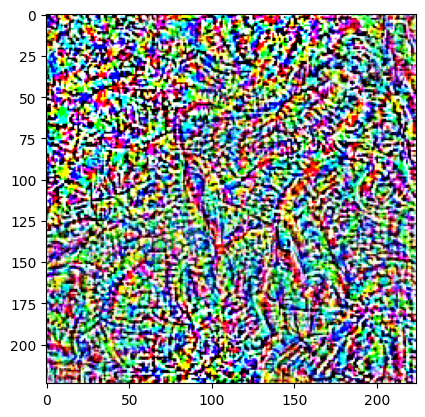

In [29]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load the pre-trained VGG19 model
vgg_model = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
# vgg_model = tf.keras.models.load_model('./vgg19_weights_tf_dim_ordering_tf_kernels.h5')

img_path = 'C:/Users/Kshat/Documents/StudyMaterial/cs671/assn5/Group_18/test/butterfly/image_0044.jpg'
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img = tf.keras.preprocessing.image.img_to_array(img)
img = tf.keras.applications.vgg19.preprocess_input(img)
img = tf.expand_dims(img, axis=0)
# Choose the last convolutional layer
last_conv_layer = vgg_model.get_layer('block5_conv4').output

# Define a model that outputs the activations of the last convolutional layer and the output class score
grad_model = tf.keras.models.Model([vgg_model.inputs], [last_conv_layer, vgg_model.output])

# Get the activations of the last convolutional layer for the image
activations = grad_model.predict(img)[0]

# Find the index of the neuron with the highest activation value
max_index = tf.argmax(tf.reduce_max(activations, axis=(0, 1, 2)))
# Choose the index of the neuron you want to visualize
neuron_index = max_index

# Define a loss function that maximizes the activation of the chosen neuron
def neuron_max_activation_loss(outputs):
    return -outputs[0][:, :, :, neuron_index]

# Define a function that generates the maximally activating patch
def generate_max_activation_patch(img_size=224, num_iterations=200, step_size=1.0):
    # Initialize a random noise image
    # img = tf.random.uniform((1, img_size, img_size, 3), 0, 1)
    # img = Image.open('C:/Users/Kshat/Documents/StudyMaterial/cs671/assn5/Group_18/test/butterfly/image_0002.jpg')
    img_path = 'C:/Users/Kshat/Documents/StudyMaterial/cs671/assn5/Group_18/test/butterfly/image_0044.jpg'
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    img = tf.expand_dims(img, axis=0)
    for i in range(num_iterations):
        # Calculate the gradient of the loss with respect to the image
        with tf.GradientTape() as tape:
            tape.watch(img)
            conv_outputs, predictions = grad_model(img)
            loss = neuron_max_activation_loss([conv_outputs, predictions])
        grads = tape.gradient(loss, img)
        # Normalize the gradient
        grads /= tf.sqrt(tf.reduce_mean(tf.square(grads))) + 1e-5
        # Update the image
        img += grads * step_size
        img = tf.clip_by_value(img, 0, 1)
    # Convert the image to a numpy array and return it
    img = np.array(img[0])
    return img

# Generate the maximally activating patch for the chosen neuron
max_activation_patch = generate_max_activation_patch()


# Visualize the patch
# plt.imshow(img, alpha=0.7)
plt.imshow(max_activation_patch, alpha = 1)
plt.imsave('activationpatch0044.png', max_activation_patch)
plt.show()

'''
ignore this cell
'''


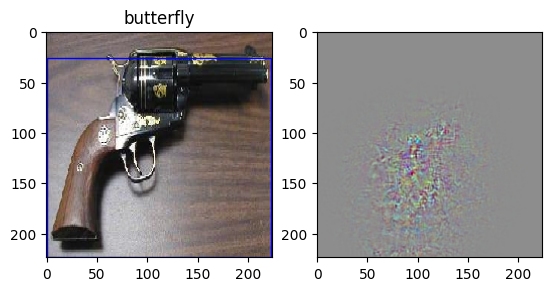

In [41]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import patches
import random

# import image
img_path = 'C:/Users/Kshat/Documents/StudyMaterial/cs671/assn5/Group_18/test/revolver/image_0025.jpg'
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img = tf.keras.preprocessing.image.img_to_array(img)
img = tf.keras.applications.vgg19.preprocess_input(img)
img = tf.expand_dims(img, axis=0)

# modified relu for guided backpropogation

@tf.custom_gradient
def customRelu(x):
    def grad(dy):
        return (tf.cast(x>0, "float32") * dy)
    return tf.nn.relu(x), grad

# get the name of the last layer of the model
def getLastLayer(model):
  for layer in model.layers:
    if 'conv' in layer.name:
      last_conv_layer = layer.name
  return last_conv_layer

vgg_model = tf.keras.applications.VGG19(include_top=True, weights='imagenet')

last_conv_layer = vgg_model.get_layer(getLastLayer(vgg_model))

conv_model = tf.keras.Model(
    inputs=[vgg_model.inputs],
    outputs=[last_conv_layer.output]
)

def activationPatch(model, img):
  # change the activation function in all convolutional layers to custom relu
  for layer in model.layers:
    if 'conv' in layer.name:
      layer.activation = customRelu

  # compute gradients by backpropogation
  with tf.GradientTape(watch_accessed_variables=False) as tape:
    inputs = tf.cast(img, tf.float32)
    tape.watch(inputs)
    preds = model(inputs)

    # get index of neuron with maximum acitvaton
    neuron = np.unravel_index(preds.numpy().argmax(), preds.shape) 

    # define mast to turn off all the other neurons
    mask = np.zeros(preds.shape)
    mask[neuron] = 1.0
    outputs = preds * mask

  grads = tape.gradient(outputs,inputs)[0]
  return neuron[1:], grads.numpy()


# do gudied backpropogation to find the influnce pixels
def guidedBackPropogation(model, img):
  # change the activation function in all convolutional layers to custom relu
  for layer in model.layers:
    if 'conv' in layer.name:
      layer.activation = customRelu

  # compute gradients by backpropogation
  with tf.GradientTape(watch_accessed_variables=False) as tape:
    inputs = tf.cast(img, tf.float32)
    tape.watch(inputs)
    preds = model(inputs)

    # get index of neuron with maximum acitvaton
    neuron = tuple(random.choice(np.argwhere(preds))) 

    # define mast to turn off all the other neurons
    mask = np.zeros(preds.shape)
    mask[neuron] = 1.0
    outputs = preds * mask

  grads = tape.gradient(outputs,inputs)[0]
  return neuron[1:], grads.numpy()

neuron, grads = activationPatch(conv_model, img)

patch_pixel_pos = np.argwhere(np.sum(np.abs(grads), axis = -1))

# get the corners of the patch
left = patch_pixel_pos[:,1].min()
right = patch_pixel_pos[:,1].max()
top = patch_pixel_pos[:,0].min()
bottom = patch_pixel_pos[:,0].max()
height = top - bottom
width = right - left
xy = (left,bottom)

neuron_b, grads_b = guidedBackPropogation(conv_model, img)

img_path = 'C:/Users/Kshat/Documents/StudyMaterial/cs671/assn5/Group_18/test/revolver/image_0025.jpg'
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))

fig, ax = plt.subplots(1,2)
ax[0].imshow(img)
# ax[0].set_title('butterfly')

rectangle = patches.Rectangle(xy, width, height, linewidth=1,edgecolor='b', facecolor='none')
ax[0].add_patch(rectangle)

neuron_2d = neuron_b[:-1]
    
# preprocess the gradients for display
grads_img = grads.copy()
grads_img -= grads_img.min()
grads_img /= grads_img.max()
grads_img = np.uint8(255 * grads_img)

# display the gradients with position of neuron selected in last layer
# plt.subplot()
# ax[1].title(f"Neuron: {neuron}")
ax[1].imshow(grads_img)